In the previous post, I showed a Bayesian method of sample size estimation for A/B/n testing. This post goes over the more conventional frequentist method. 

As before, here's the context. Say we're trying to test which variant of an email message generates the highest response rate. We consider $k$ different messages and send out $n$ emails for each message. After we wait for responses, we should be able to tell which message yielded the highest response rate as long as we set $n$ high enough. But we generally can't send out too many messages: say we're capped at $N$ total. How do we choose the highest $k$ that still allows us to confidently pick which message got the highest response rate?

## Frequentist Two-Arm Estimation

If we only have two messages (or 'arms' in the standard terminology), we might naively use a t-test to see if the observed difference in mean response rates $\hat{\delta}$ was statistically significant. Let $\hat{\sigma}$ be the pooled standard deviation. Then if the true difference in mean response rates $\delta$ is zero (the null hypothesis), $t = \frac{\sqrt{n}\hat{\delta}}{\sqrt{2}\hat{\sigma}}$ will be T distributed with $2n-2$ dof. To get a false positive rate of $\alpha$, we can reject the null hypothesis when $t > t_{1-\alpha}$ where $t_{1-\alpha}$ gives the $1-\alpha$ quantile of the Student's t distribution. Under the alternative hypothesis that $\delta = \delta_0 > 0$, $t$ will actually come from a non-central t distribution (ignoring the differences in arm variance). We can see this because $\sqrt{n}(\hat{\delta} - \delta_0)/\sqrt{2}\sigma$ comes from a standard normal distribution, so $\sqrt{n}\hat{\delta}/\sqrt{2}\sigma$ is normal with mean $\delta_0 \sqrt{n}$. This means that the power of our test will be the survival function of a $2n-2$ degree non-central T distribution with noncentrality parameter $\delta_0 \sqrt{n}$ evaluated at $t_{1-\alpha}$. We can find the number of samples $n$ that produces a desired power $\beta$ with a simple binary search. This calculation is implemented within the `statsmodels` library as follows:

In [1]:
from statsmodels.stats import power
from scipy.optimize import brentq
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()

In [2]:
powers = [0.8, 0.85, 0.9]

In [3]:
freq_df_t = pd.concat([pd.DataFrame({
    'samples': [2 * power.tt_ind_solve_power(effect_size=delta, alpha=alpha, power=p, alternative='larger') for p in powers],
    'power': powers, 'delta': delta, 'alpha': alpha})
    for delta in [0.01, 0.015, 0.02]
    for alpha in [0.2, 0.15, 0.1]], ignore_index=True)

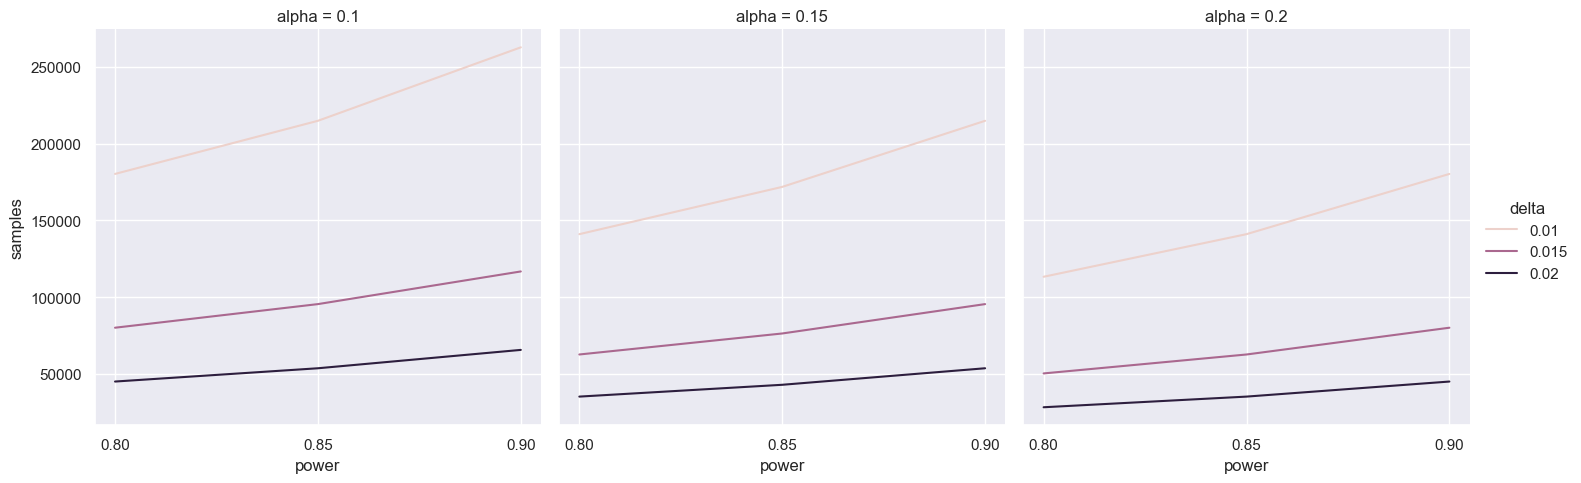

In [4]:
for ax in sns.relplot(data=freq_df_t, x='power', y='samples', hue='delta', col='alpha', kind='line').axes.ravel():
    ax.set_xticks(powers)

This suggests we'd need a truly massive number of samples! Fortunately, things aren't as bad as they seem. We can use a Z-test instead.

Say response rates are $\theta_0$ and $\theta_1$ with difference $\delta$. The difference of observed arm means $\hat{\delta}$ will be approximately normal around $\delta$ with variance $\frac{\theta_0(1-\theta_0) + \theta_1(1-\theta_1)}{n}$. Let $\sigma_0^2 =2\theta_0(1-\theta_0)$ and  $\sigma_1^2 =\theta_0(1-\theta_0) + \theta_1(1-\theta_1)$.  if $\delta = 0$ and we reject when $\hat{\delta} > \frac{\sigma_0}{\sqrt{n}} z_{1 - \alpha}$, we'll have a false positive rate of $\alpha$. If $\delta = \delta_0$, on the other hand, then $\hat{\delta} - \delta_0$ will be normal with variance $\sigma_1^2/n$, so rejecting if $\hat{\delta} > \delta_0 + \frac{\sigma_1}{\sqrt{n}} z_{1 - \beta}$ would give us power $\beta$. We can choose $n$ so that these critical values are the same.

A little algebra tells us that $n = \frac{(\sigma_0 z_{1 - \alpha} - \sigma_1 z_{1 - \beta})^2}{\delta_0^2}$. Once again, this is already implemented in `statsmodels`.

In [5]:
t = 0.04

In [6]:
freq_df_z = pd.concat([pd.DataFrame({
    'samples': [2 * power.normal_sample_size_one_tail(d, p, alpha,
                        std_null=np.sqrt(2 * t * (1-t)),
                        std_alternative=np.sqrt(t * (1-t) + (t+d)*(1 - (t+d))))
                for p in powers],
    'power': powers, 'delta': d, 'alpha': alpha})
    for d in [0.01, 0.015, 0.02]
    for alpha in [0.2, 0.15, 0.1]], ignore_index=True)

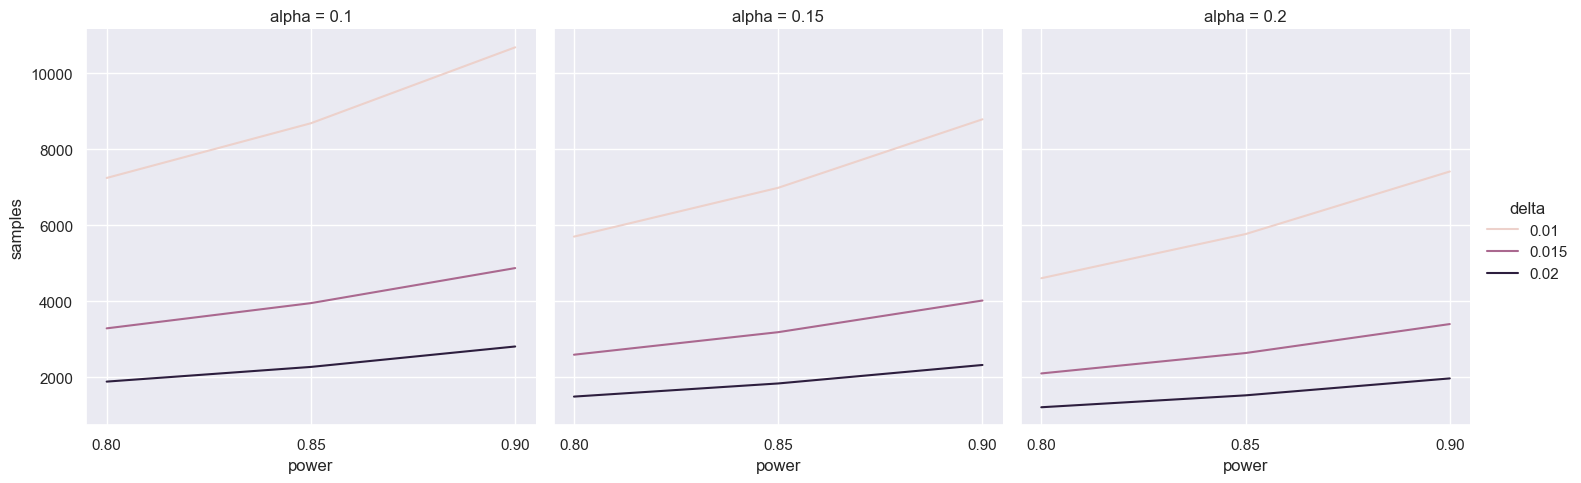

In [7]:
for ax in sns.relplot(data=freq_df_z, x='power', y='samples', hue='delta', col='alpha', kind='line').axes.ravel():
    ax.set_xticks(powers)

## Frequentist Multi-Arm Estimation

With more than two arms, we end up testing more than one null hypothesis. Specifically, we'll want to test the null hypothesis that arm $i$ has a higher mean than arm $j$ for every pair arms $i,j$. We'll reject this hypothesis when $\hat{\delta_{i,j}} > c$ for a specific value of $c$. Our family-wise false positive rate $1 - \alpha$ must now cover the probability that we mistakenly reject any of these tests. If $\hat{\delta}_{i,j} > c$ for any $i,j$, it will also be true that $\delta^\star > c$ where $\delta^\star$ is the largest observed difference in means between any pair of arms. We can show that $\delta^\star$ follows a known distribution.

In general, if $F$ is a distribution's cdf, the joint probability that each of $k$ independent draws from the distribution are between $a$ and $a+\delta$ is given by $(F(a + \delta) - F(a))^k$. This makes the density at $a$ given by $k f(a)(F(a + \delta) - F(a))^{k-1}$. We want to integrate over all $a$: $\int_{-\infty}^\infty k f(a)(F(a + \delta) - F(a))^{k-1}\, da$.

This distribution over the largest difference within $k$ samples is known as the *Studentized range distribution* when $F$ is the cdf of a Student's t distribution. This is built into `scipy`! And because a normal distribution is just a Student's t distribution with infinite degrees of freedom, this covers a largest difference between normal samples as well, which I'll refer to as a *range distribution*.

Say each of the per-arm differences are normal with approximately the same variance $\sigma^2$. We can reject the null hypothesis that all the inter-arm differences are zero when $\delta^\star > \frac{\sigma}{\sqrt{n}} q_{1-\alpha}$ to get a family-wise false positive rate of $\alpha$, where $q_{1-\alpha}$ gives the $1-\alpha$ quantile of the range distribution. If we also reject when $\delta^\star > \delta_0 +  \frac{\sigma}{\sqrt{n}} q_{1-\beta}$, we'd have power $\beta$ when the true maximum difference is $\delta_0$. Once again, we can solve for when these critical values are equal to find the necessary number of samples; unfortunately the algebra here isn't built into `statsmodels`, so we'll have to do it ourselves.

In [8]:
def range_sample_size(k, theta=0.06, delta=0.015, alpha=0.90, beta=0.8):
    q0 = stats.studentized_range.ppf(1 - alpha, k, np.inf)
    q1 = stats.studentized_range.ppf(1 - beta, k, np.inf)
    theta1 = theta + delta
    return k * theta1 * (1 - theta1) * ((q1 - q0) / delta)**2

In [9]:
ks = range(2, 5)

In [10]:
freq_df_q = pd.concat([pd.DataFrame({
    'samples': [range_sample_size(k, delta=delta, theta=theta, alpha=alpha) for k in ks],
    'k': ks, 'delta': delta, 'theta': theta, 'alpha': alpha})
    for delta in [0.01, 0.015, 0.02]
    for theta in [0.04, 0.05]
    for alpha in [0.2, 0.15, 0.1]], ignore_index=True)

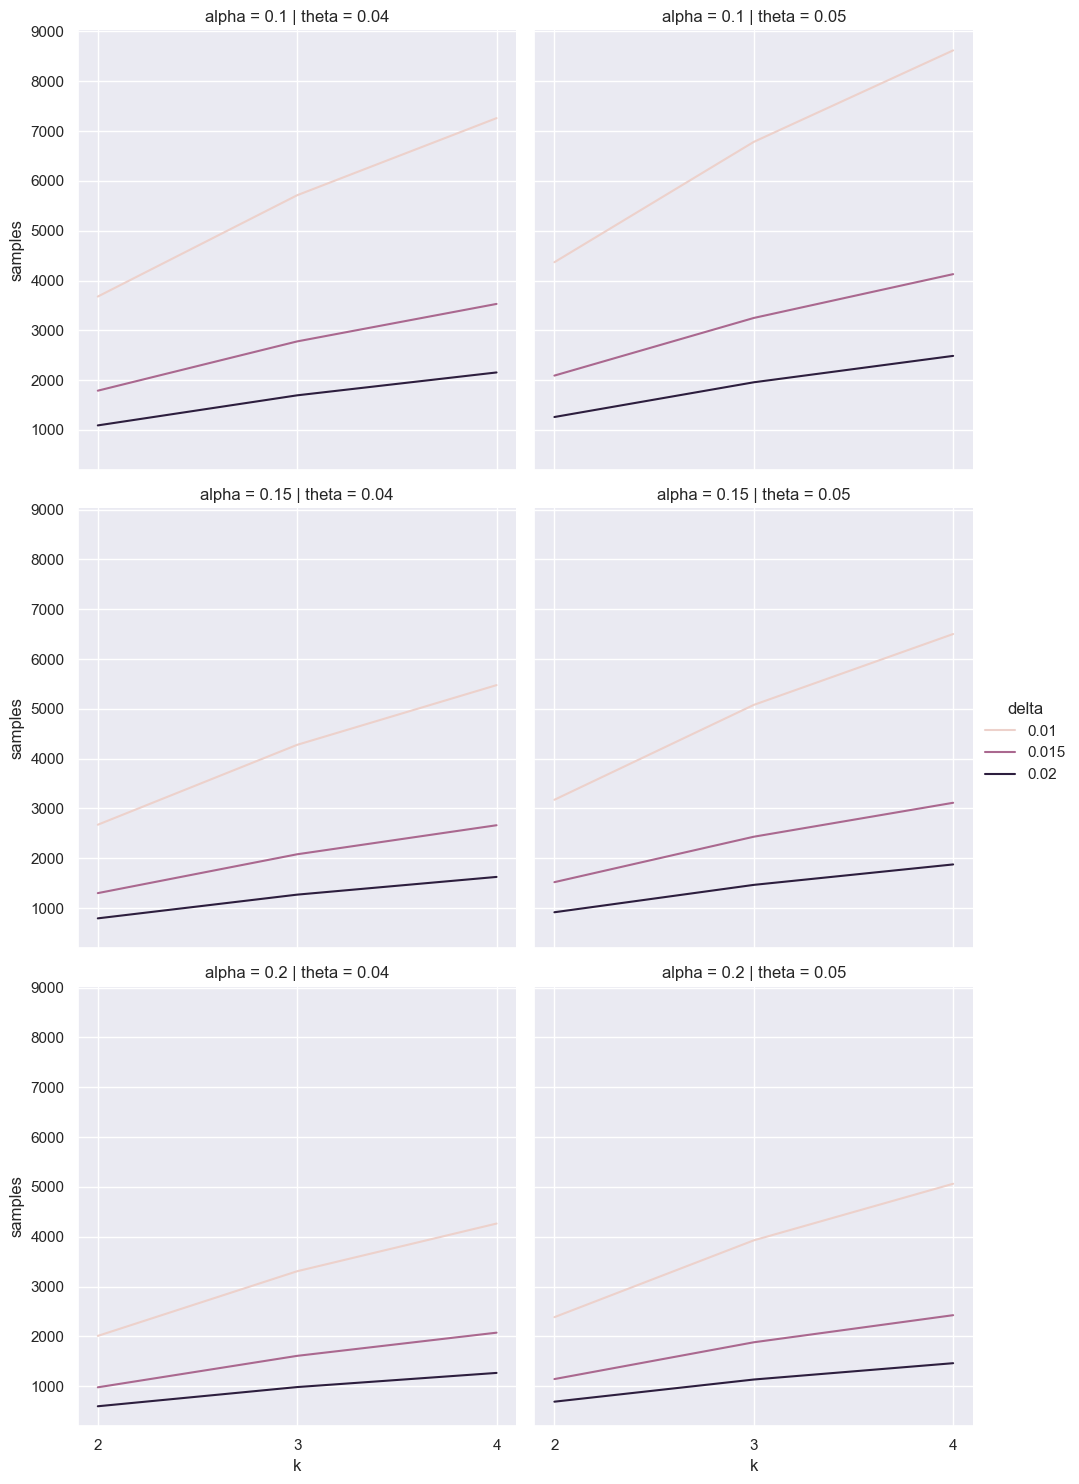

In [11]:
for ax in sns.relplot(data=freq_df_q, x='k', y='samples', hue='delta', col='theta', row='alpha', kind='line').axes.ravel():
    ax.set_xticks(list(ks))